# Find the perpendicular distance from a point to each isochrone as a function of age and also direct distance from Gaia parameters


In [2]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.chdir('Data')
pkl_file = open('isochrones.pkl', 'rb')
stacked_isochrones = pickle.load(pkl_file)

pkl_file = open('columns.pkl', 'rb')
x_columns = pickle.load(pkl_file)

pkl_file = open('x_values.pkl', 'rb')
x_values = pickle.load(pkl_file)

pkl_file = open('isoc_cols.pkl', 'rb')
isoc_columns = pickle.load(pkl_file)

x_input=pd.read_csv('x_input')
x_input_err=pd.read_csv('x_input_err')

os.chdir('..')

In [3]:
import torch
def find_nearest(array, value):
    #array = np.asarray(array)
    idx = (torch.abs(array - value)).argmin()
    return array[idx],idx

def isochrone_selector(feh,age):
    '''if(feh<-4 or feh>0.5):
        raise NotImplementedError
    if(age<5 or age>10.3):
        raise NotImplementedError
    else:'''
    logagegrid = torch.tensor(np.linspace(5,10.3,105))
    fehgrid = torch.tensor(np.linspace(-4,0.5,90))
    feh,feh_idx=find_nearest(fehgrid,feh)
    age,age_idx=find_nearest(logagegrid,age)

    return feh_idx*len(logagegrid)+age_idx

def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [4]:
stacked_isochrones.shape

(9450, 15, 457)

# Find the perpendicular values

In [5]:
stacked_isochrones=torch.tensor(stacked_isochrones)

In [6]:
x_values=torch.tensor(x_values)

In [7]:
stacked_isochrones.shape

torch.Size([9450, 15, 457])

(20.0, -15.0)

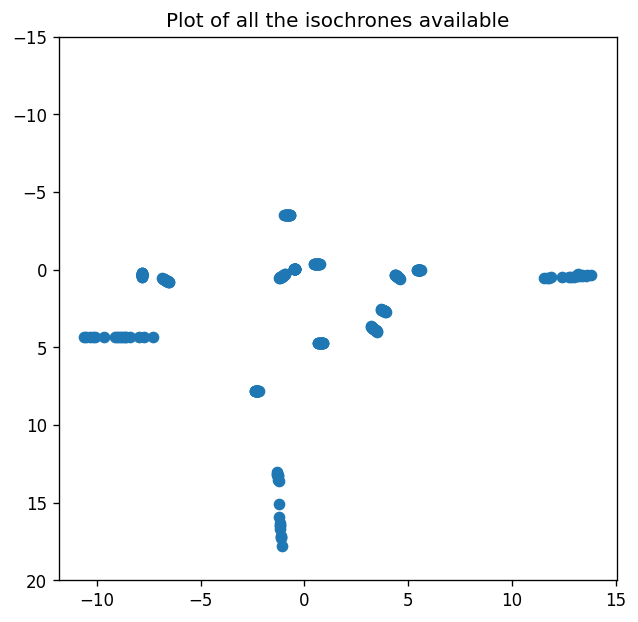

In [17]:
isochrone=pd.DataFrame(np.array(stacked_isochrones[1000]).transpose(),columns=isoc_columns).dropna()
fig = plt.figure(figsize=(6, 6), dpi=120)

plt.scatter(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                    )
    
    

plt.title('Plot of all the isochrones available')
plt.ylim(20, -15)

In [10]:
def perpendicular_dist(i,age):

    isochrone=torch.cat([x_values[i],stacked_isochrones[isochrone_selector(x_values[i][column_index('mh_gspphot') ][0],age)]],dim=0)
    isochrone=isochrone.reshape((1,)+isochrone.shape)


    truth_1=(isochrone[:,column_index('G'),:]+-(isochrone[:,column_index('bp_rp'),:])*isochrone[:,column_index('p_slopes'),:]<=isochrone[:,column_index('high_c'),:]) #box selection
    truth_1=truth_1.reshape(truth_1.shape[0],1,truth_1.shape[1])
    truth_2=(isochrone[:,column_index('low_c'),:]<=isochrone[:,column_index('G'),:]-(isochrone[:,column_index('bp_rp'),:])*isochrone[:,column_index('p_slopes'),:])
    truth_2=truth_2.reshape(truth_2.shape[0],1,truth_2.shape[1])
    truth=truth_1*truth_2
    # ^box selection

    # projection onto the nearest line
    x=((1/torch.sqrt(1+isochrone[:,column_index('slopes'),:]**2))*(isochrone[:,column_index('G'),:]-(isochrone[:,column_index('bp_rp'),:])*isochrone[:,column_index('slopes'),:]-isochrone[:,column_index('Gaia_G_EDR3'),:] + isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('BPRP'),:]))
    # taking the minimum
    idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),1)
    x=x.gather(1,idx.view(-1,1))
    #error needs to be corrected for absolute magnitude 
    x_err=(1/(1+isochrone[:,column_index('slopes'),:]**2))*isochrone[:,column_index('phot_g_mean_mag_error'),:]**2+(isochrone[:,column_index('slopes'),:]*isochrone[:,column_index('bp_rp_error'),:])**2
    x_err=x_err.gather(1,idx.view(-1,1))
    isochrone=torch.cat((isochrone,x.reshape(x.shape[0],1,x.shape[1]).repeat(1,1,(isochrone).shape[-1]),x_err.reshape(x_err.shape[0],1,x_err.shape[1]).repeat(1,1,(isochrone).shape[-1])),1)

    dist=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros_like(x),torch.eye(len(x))+torch.diag(x_err**2))
    
    try:# serious issues here
                
        log_l=dist.log_prob(x)
                

    except:
                
        log_l=torch.inf

    return log_l, isochrone            

In [11]:
perpendicular_dist(1,6)

(tensor([-17.2820], dtype=torch.float64),
 tensor([[[ 2.8261e+02,  2.8261e+02,  2.8261e+02,  ...,  2.8261e+02,
            2.8261e+02,  2.8261e+02],
          [-6.2239e+00, -6.2239e+00, -6.2239e+00,  ..., -6.2239e+00,
           -6.2239e+00, -6.2239e+00],
          [ 4.1497e-01,  4.1497e-01,  4.1497e-01,  ...,  4.1497e-01,
            4.1497e-01,  4.1497e-01],
          ...,
          [-1.8768e+00,  4.3981e+00,  4.4364e+00,  ...,         nan,
                   nan,         nan],
          [ 5.7207e+00,  5.7207e+00,  5.7207e+00,  ...,  5.7207e+00,
            5.7207e+00,  5.7207e+00],
          [ 1.4755e-05,  1.4755e-05,  1.4755e-05,  ...,  1.4755e-05,
            1.4755e-05,  1.4755e-05]]], dtype=torch.float64))

# Find perpendicular distances over all ages

In [12]:
log_l=[]
isocs=[]
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(5,10.3,105)
for age in logagegrid:
    output=perpendicular_dist(100,age)
    log_l.append(output[0])
    isocs.append(output[1])
    

In [13]:
log_l

[inf,
 inf,
 inf,
 inf,
 inf,
 tensor([-2.7737], dtype=torch.float64),
 tensor([-1.0153], dtype=torch.float64),
 tensor([-2.6715], dtype=torch.float64),
 tensor([-3.3507], dtype=torch.float64),
 tensor([-0.9250], dtype=torch.float64),
 tensor([-4.7504], dtype=torch.float64),
 tensor([-11.7921], dtype=torch.float64),
 tensor([-0.9252], dtype=torch.float64),
 tensor([-9.6999], dtype=torch.float64),
 tensor([-9.5706], dtype=torch.float64),
 tensor([-1.7642], dtype=torch.float64),
 tensor([-9.4500], dtype=torch.float64),
 tensor([-9.3239], dtype=torch.float64),
 tensor([-3.0858], dtype=torch.float64),
 tensor([-1.8016], dtype=torch.float64),
 tensor([-5.5877], dtype=torch.float64),
 tensor([-1.5985], dtype=torch.float64),
 tensor([-0.9383], dtype=torch.float64),
 tensor([-5.3255], dtype=torch.float64),
 tensor([-5.3919], dtype=torch.float64),
 tensor([-0.9425], dtype=torch.float64),
 tensor([-1.8687], dtype=torch.float64),
 tensor([-2.5848], dtype=torch.float64),
 tensor([-9.6888], dtype=t

In [14]:
def isoc_column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0]

In [15]:
isochrone[column_index('Gaia_G_EDR3')-n]

NameError: name 'n' is not defined

Text(0.5, 1.0, 'Plot of all the isochrones available')

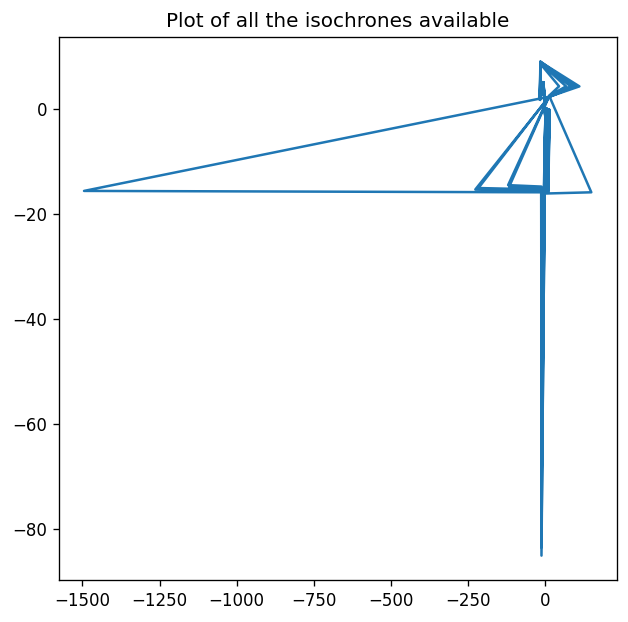

In [ ]:
fig = plt.figure(figsize=(6, 6), dpi=120)
n=len(x_columns)
isochrone = stacked_isochrones[0]
    
plt.plot(isochrone[column_index('Gaia_BP_EDR3')-n]-isochrone[column_index('Gaia_RP_EDR3')-n], isochrone[column_index('Gaia_G_EDR3')-n])
    
    

plt.title('Plot of all the isochrones available')
